In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score,silhouette_samples

## Carga del dataset y análisis exploratorio de datos

In [268]:
ruta_al_csv = '/content/Crop_recommendation.csv'
df = pd.read_csv(ruta_al_csv)

In [269]:
df.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB


Notamos que 'label' es una variable categórica. Los demás atributos son numéricos.

In [5]:
df.describe()

,N,P,K,temperature,humidity,ph,rainfall
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.551818,53.362727,48.149091,25.616244,71.481779,6.469480,103.463655
std,36.917334,32.985883,50.647931,5.063749,22.263812,0.773938,54.958389
min,0.000000,5.000000,5.000000,8.825675,14.258040,3.504752,20.211267
25%,21.000000,28.000000,20.000000,22.769375,60.261953,5.971693,64.551686
50%,37.000000,51.000000,32.000000,25.598693,80.473146,6.425045,94.867624
75%,84.250000,68.000000,49.000000,28.561654,89.948771,6.923643,124.267508
max,140.000000,145.000000,205.000000,43.675493,99.981876,9.935091,298.560117


In [6]:
df['label'].unique()

array(['rice', 'maize', 'chickpea', 'kidneybeans', 'pigeonpeas',
       'mothbeans', 'mungbean', 'blackgram', 'lentil', 'pomegranate',
       'banana', 'mango', 'grapes', 'watermelon', 'muskmelon', 'apple',
       'orange', 'papaya', 'coconut', 'cotton', 'jute', 'coffee'],
      dtype=object)

### Matriz de correlación

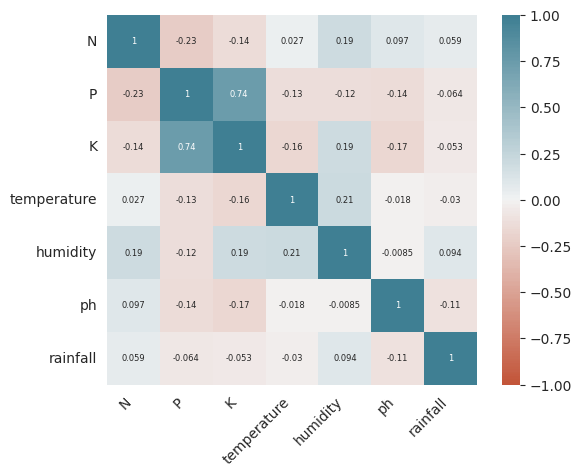

In [270]:
corr = df.drop(['label'], axis=1).corr()
ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot = True,
    annot_kws = {'size': 6}
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.show()

A partir de la matriz de correlación, se puede notar que los atributos 'P' y 'K' son aquellos que más se correlacionan, con un valor de 0.74. Los demás atributos no poseen una correlación tan marcada.

### Estandarización de datos
Realizamos la estandarización de los datos basada en la desviación estándar

In [271]:
df_sub = df.drop(['label'], axis=1)
df_sub_std = (df_sub-df_sub.mean())/df_sub.std()

In [272]:
df_sub_std.head()

,N,P,K,temperature,humidity,ph,rainfall
0,1.068554,-0.344472,-0.101664,-0.935374,0.472559,0.043292,1.809949
1,0.933117,0.140584,-0.141153,-0.759473,0.396961,0.734706,2.241548
2,0.255928,0.049636,-0.081920,-0.515781,0.486843,1.771108,2.920402
3,0.635154,-0.556684,-0.160897,0.172768,0.389717,0.660158,2.536471
4,0.743504,-0.344472,-0.121409,-1.083401,0.454688,1.497527,2.897714


### Boxplot DataFrame completo

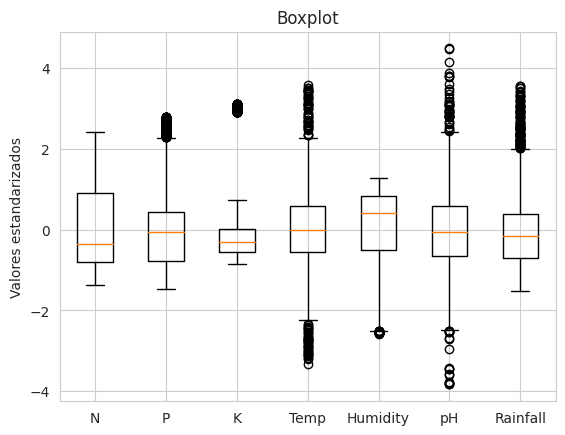

In [273]:
data = [df_sub_std['N'], df_sub_std['P'], df_sub_std['K'], df_sub_std['temperature'], df_sub_std['humidity'], df_sub_std['ph'], df_sub_std['rainfall']]
labels = ['N', 'P', 'K', 'Temp', 'Humidity', 'pH', 'Rainfall']

plt.boxplot(data)
plt.xticks(range(1, len(labels) + 1), labels)
plt.xlabel('')
plt.ylabel('Valores estandarizados')
plt.title('Boxplot')

plt.show()

Notamos que aparecen una serie de outliers en algunas características.
Pensamos que puede deberse a que están todos los cultivos juntos en el mismo gráfico y algunos se pueden comportar de manera distinta a otros, por eso pueden visualizarse esos outliers.

### Gráfico boxplot para cada label
 Lo que buscamos es ver si existen outliers para cada label por separado.
 De esta forma, si existieran, analizaremos un criterio para removerlos. De lo contrario continuaremos sin realizar modificaciones.

In [274]:
# Creamos un diccionario para almacenar los DataFrames estandarizados para cada label y estandarizamos por desvío std
etiquetas = df['label'].unique()
dfs_std = {}

for etiqueta in etiquetas:
    df_etiqueta = df[df['label'] == etiqueta]
    df_etiqueta_sub = df_etiqueta.drop(['label'], axis=1)
    df_etiqueta_std = (df_etiqueta_sub - df_etiqueta_sub.mean()) / df_etiqueta_sub.std()
    dfs_std[etiqueta] = df_etiqueta_std

In [275]:
dfs_std['rice'].head()

,N,P,K,temperature,humidity,ph,rainfall
0,0.848298,-0.705885,1.062397,-1.383167,-0.190412,0.100839,-0.969490
1,0.428764,1.318159,0.383549,-0.944665,-1.377047,0.796971,-0.277780
2,-1.668907,0.938650,1.401821,-0.337165,0.033800,1.840446,0.810197
3,-0.494211,-1.591405,0.044125,1.379315,-1.490755,0.721915,0.194884
4,-0.158584,-0.705885,0.722973,-1.752182,-0.470923,1.564999,0.773835


In [276]:
# Creamos diccionario que tendrá como key las labels y como values una serie con los datos de cada característica
data_label = {}
for label in dfs_std:
  data = [dfs_std[label]['N'], dfs_std[label]['P'], dfs_std[label]['K'], dfs_std[label]['temperature'], dfs_std[label]['humidity'], dfs_std[label]['ph'], dfs_std[label]['rainfall']]
  data_label[label] = data

In [277]:
data_label['rice'][0] # Valores para 'N' en el cultivo rice

0     0.848298
1     0.428764
2    -1.668907
3    -0.494211
4    -0.158584
        ...   
95    0.680484
96    1.100018
97   -1.668907
98   -0.158584
99   -1.249373
Name: N, Length: 100, dtype: float64

In [278]:
data_label.keys()

dict_keys(['rice', 'maize', 'chickpea', 'kidneybeans', 'pigeonpeas', 'mothbeans', 'mungbean', 'blackgram', 'lentil', 'pomegranate', 'banana', 'mango', 'grapes', 'watermelon', 'muskmelon', 'apple', 'orange', 'papaya', 'coconut', 'cotton', 'jute', 'coffee'])

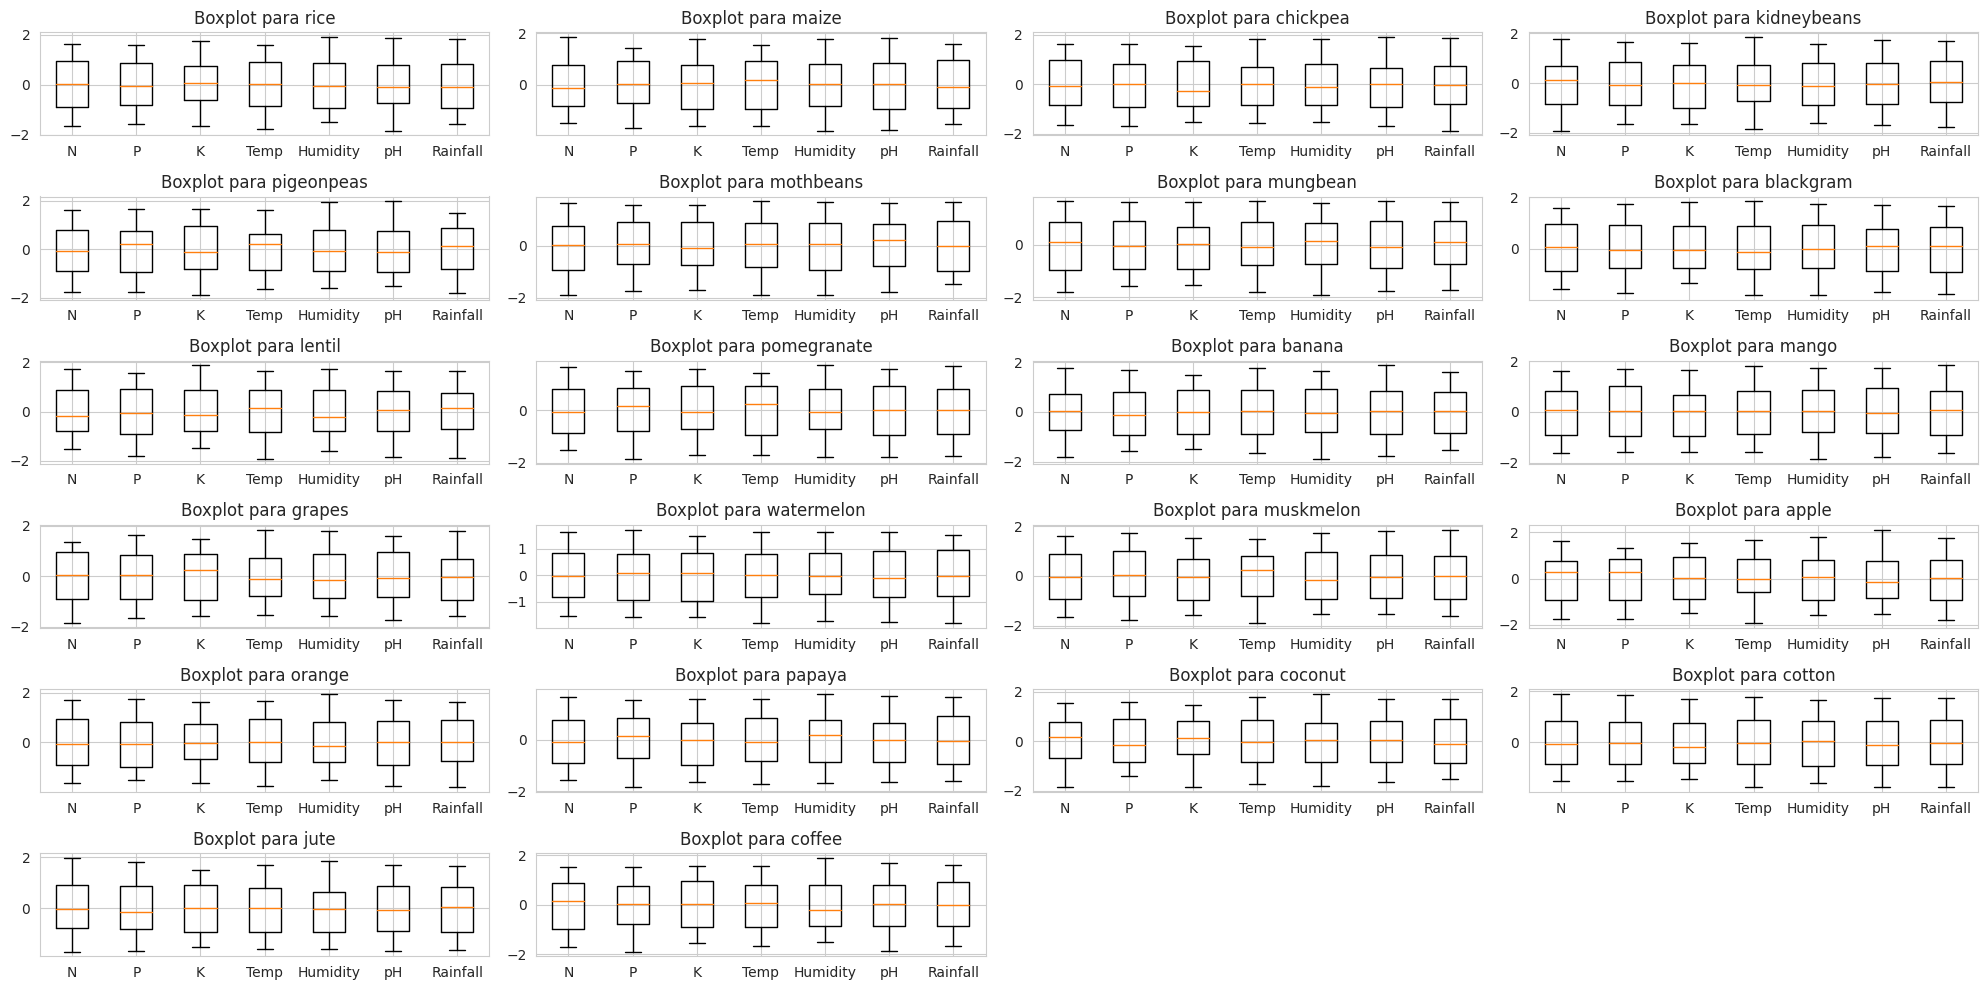

In [279]:
# Graficamos los boxplot por cada label
labels = ['N', 'P', 'K', 'Temp', 'Humidity', 'pH', 'Rainfall']
num_etiquetas = len(data_label)
num_columnas = 4
num_filas = (num_etiquetas + num_columnas - 1) // num_columnas # Número de filas necesario para acomodar todos los subplots

fig, axes = plt.subplots(num_filas, num_columnas, figsize=(20, 10))

for i, (label, data) in enumerate(data_label.items()):
    fila = i // num_columnas # Ubicación de fila y columna en la matriz de subplots, en función del índice
    columna = i % num_columnas

    ax = axes[fila, columna] # Subplot actual
    ax.boxplot(data)
    ax.set_xticks(range(1, len(labels) + 1))
    ax.set_xticklabels(labels)
    ax.set_title(f'Boxplot para {label}')

# Eliminamos subplots vacíos
for i in range(num_etiquetas, num_filas * num_columnas):
    fig.delaxes(axes[i // num_columnas, i % num_columnas])

plt.tight_layout()
plt.show()

Observando los boxplots, no se han visualizado outliers para cada label por separado, por lo tanto decidimos continuar sin realizar modificaciones.

## PCA


In [280]:
# Obtener todas las componentes principales
pca = PCA(n_components=df_sub.shape[1])

pca_features = pca.fit_transform(df_sub_std)

# PC dataframe
pca_df = pd.DataFrame(
    data=pca_features,
    columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7'])
pca_df['label'] = df['label']

In [281]:
pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,label
0,-0.582737,-0.844394,1.373031,-1.613762,0.308154,-0.095975,-0.025234,rice
1,-0.474527,-0.784716,1.251893,-1.792355,1.107493,-0.532134,-0.280479,rice
2,-0.633924,-0.694365,1.179064,-1.817692,2.522690,-0.538428,-0.105943,rice
3,-1.047682,-1.087411,1.393035,-0.982177,1.448452,-0.656779,0.275209,rice
4,-0.873059,-0.658523,1.455354,-2.334481,1.959188,-0.317952,0.052728,rice


### Eigenvectors


Se utilizan para encontrar las direcciones principales de variabilidad en un conjunto de datos.

In [282]:
pd.DataFrame(pca.components_, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7'], index=['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall'])

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
N,-0.302191,0.643787,0.622607,-0.212428,-0.068483,-0.226943,-0.072532
P,-0.334107,-0.034358,-0.283829,-0.359487,-0.737917,0.220657,-0.290158
K,-0.112045,-0.109939,-0.163173,-0.248228,-0.213599,-0.548520,0.735267
temperature,-0.541651,-0.046293,-0.154867,0.690826,-0.067171,-0.395700,-0.205318
humidity,-0.507785,0.082331,0.033425,0.154865,0.128871,0.651881,0.518382
ph,-0.482904,-0.376847,-0.028967,-0.500418,0.547871,-0.125712,-0.239930
rainfall,-0.008473,-0.649104,0.692268,0.111282,-0.289624,0.040028,0.038577


In [283]:
# Creamos función para acumular la varianza
def acumular(numbers):
     sum = 0
     var_c = []
     for num in numbers:
        sum += num
        var_c.append(sum)
     return var_c

In [284]:
pca.explained_variance_ratio_

array([0.27588831, 0.18484431, 0.15378704, 0.14612731, 0.11513263,
       0.09665166, 0.02756874])

In [285]:
var_c = acumular(pca.explained_variance_ratio_)
pca_rtd = pd.DataFrame({'Eigenvalues':pca.explained_variance_, 'Proporción de variancia explicada':pca.explained_variance_ratio_, 'Proporción acumulado de variancia explicada': var_c})
pca_rtd

,Eigenvalues,Proporción de variancia explicada,Proporción acumulado de variancia explicada
0,1.931218,0.275888,0.275888
1,1.293910,0.184844,0.460733
2,1.076509,0.153787,0.614520
3,1.022891,0.146127,0.760647
4,0.805928,0.115133,0.875780
5,0.676562,0.096652,0.972431
6,0.192981,0.027569,1.000000


### Gráfico de variancia acumulada

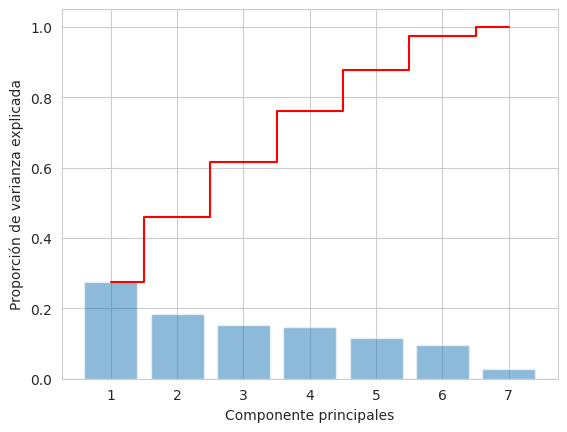

In [286]:
plt.bar(range(1,8), pca.explained_variance_ratio_,
        alpha=0.5,
        align='center')
plt.step(range(1,8), np.cumsum(pca.explained_variance_ratio_),
         where='mid',
         color='red')
plt.ylabel('Proporción de varianza explicada')
plt.xlabel('Componente principales')
plt.show()

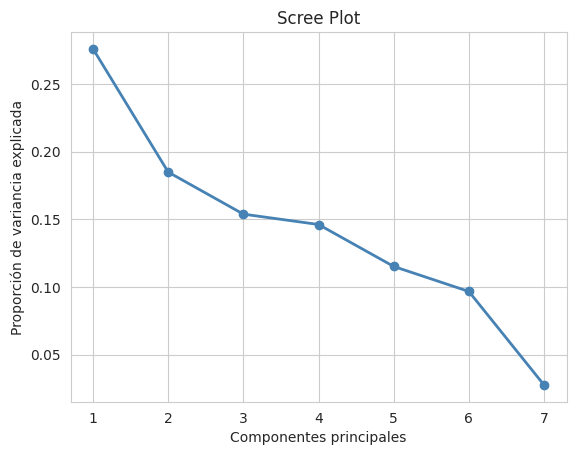

In [287]:
# Gráfico del codo
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='steelblue')
plt.title('Scree Plot')
plt.xlabel('Componentes principales')
plt.ylabel('Proporción de variancia explicada')
plt.show()

Criterios de selección:

- Proporción de variancia acumulada (~75% -80%)
​
- Criterio de Kaiser (eigenvalues > 1)
​
- Gráfico del codo (Scree)

Al observar el gráfico del codo se logra visualizar un quiebre en el PC4. Además, considerando el criterio de Kaiser y la proporción de variancia acumulada **definimos seleccionar PC1 - PC2 - PC3 - PC4**, ya que son aquellos con eigenvalues > 1 y además acumulan el 76% de la variancia.

### Matriz de correlación entre PC seleccionados

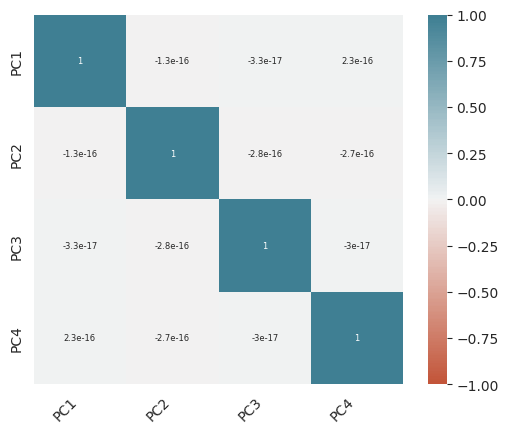

In [288]:
corr = pca_df[['PC1', 'PC2', 'PC3', 'PC4']].corr()
ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot = True,
    annot_kws = {'size': 6}
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.show()

Vemos que la matriz de correlación entre las PC seleccionadas es una matriz diagonal, por lo tanto podemos decir que no tienen ninguna relación las PC entre ellas.

### Scatter plots

In [289]:
# Lista de colores personalizada
custom_palette = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
    '#FF5733', '#33FF57', '#5733FF', '#FFFF33', '#33FFFF',
    '#FF33FF', '#FF9933', '#33FF99', '#9933FF', '#99FF33',
    '#FF3366', '#2F4F4F']

In [290]:
fig = px.scatter(pca_features, x=0, y=1, color = pca_df["label"], labels={'color': 'label'}, color_discrete_sequence=custom_palette)
fig.update_layout(title = "Biplot",width = 1200,height = 600)
fig.show()
fig = px.scatter_3d(pca_features, x=0, y=1, z=2,
              color=pca_df["label"],  labels={'color': 'label'}, color_discrete_sequence=custom_palette)
fig.show()

## Isomap


Analizamos isomap para distintos valores de n_neighbors y así chequear los diferentes resultados.

In [295]:
# n_neighbors = 55
isomap_df_55 = Isomap(n_neighbors=55, n_components=2)
isomap_df_55.fit(df_sub_std)
projections_isomap_55 = isomap_df_55.transform(df_sub_std)
manifold_2D_55 = pd.DataFrame(projections_isomap_55, columns=['PC1', 'PC2'])
manifold_2D_55['label'] = df['label'].to_numpy()

In [296]:
# n_neighbors = 45
isomap_df_45 = Isomap(n_neighbors=45, n_components=2)
isomap_df_45.fit(df_sub_std)
projections_isomap_45 = isomap_df_45.transform(df_sub_std)
manifold_2D_45 = pd.DataFrame(projections_isomap_45, columns=['PC1', 'PC2'])
manifold_2D_45['label'] = df['label'].to_numpy()

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_isomap.py:352: UserWarning:

The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.

/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.



In [307]:
# n_neighbors = 20
isomap_df_20 = Isomap(n_neighbors=20, n_components=2)
isomap_df_20.fit(df_sub_std)
projections_isomap_20 = isomap_df_20.transform(df_sub_std)
manifold_2D_20 = pd.DataFrame(projections_isomap_20, columns=['PC1', 'PC2'])
manifold_2D_20['label'] = df['label'].to_numpy()

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_isomap.py:352: UserWarning:

The number of connected components of the neighbors graph is 3 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.

/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.



In [306]:
# n_neighbors = 100
isomap_df_100 = Isomap(n_neighbors=100, n_components=2)
isomap_df_100.fit(df_sub_std)
projections_isomap_100 = isomap_df_100.transform(df_sub_std)
manifold_2D_100 = pd.DataFrame(projections_isomap_100, columns=['PC1', 'PC2'])
manifold_2D_100['label'] = df['label'].to_numpy()

In [299]:
# Chequeamos df, por ejemplo para n_neighbors=55
manifold_2D_55.head()

,PC1,PC2,label
0,-1.597277,-2.031209,rice
1,-1.444353,-1.792512,rice
2,-1.711220,-2.059155,rice
3,-1.081042,-2.023589,rice
4,-1.852061,-2.301729,rice


<ipython-input-309-ca3b5dee97aa>:11: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



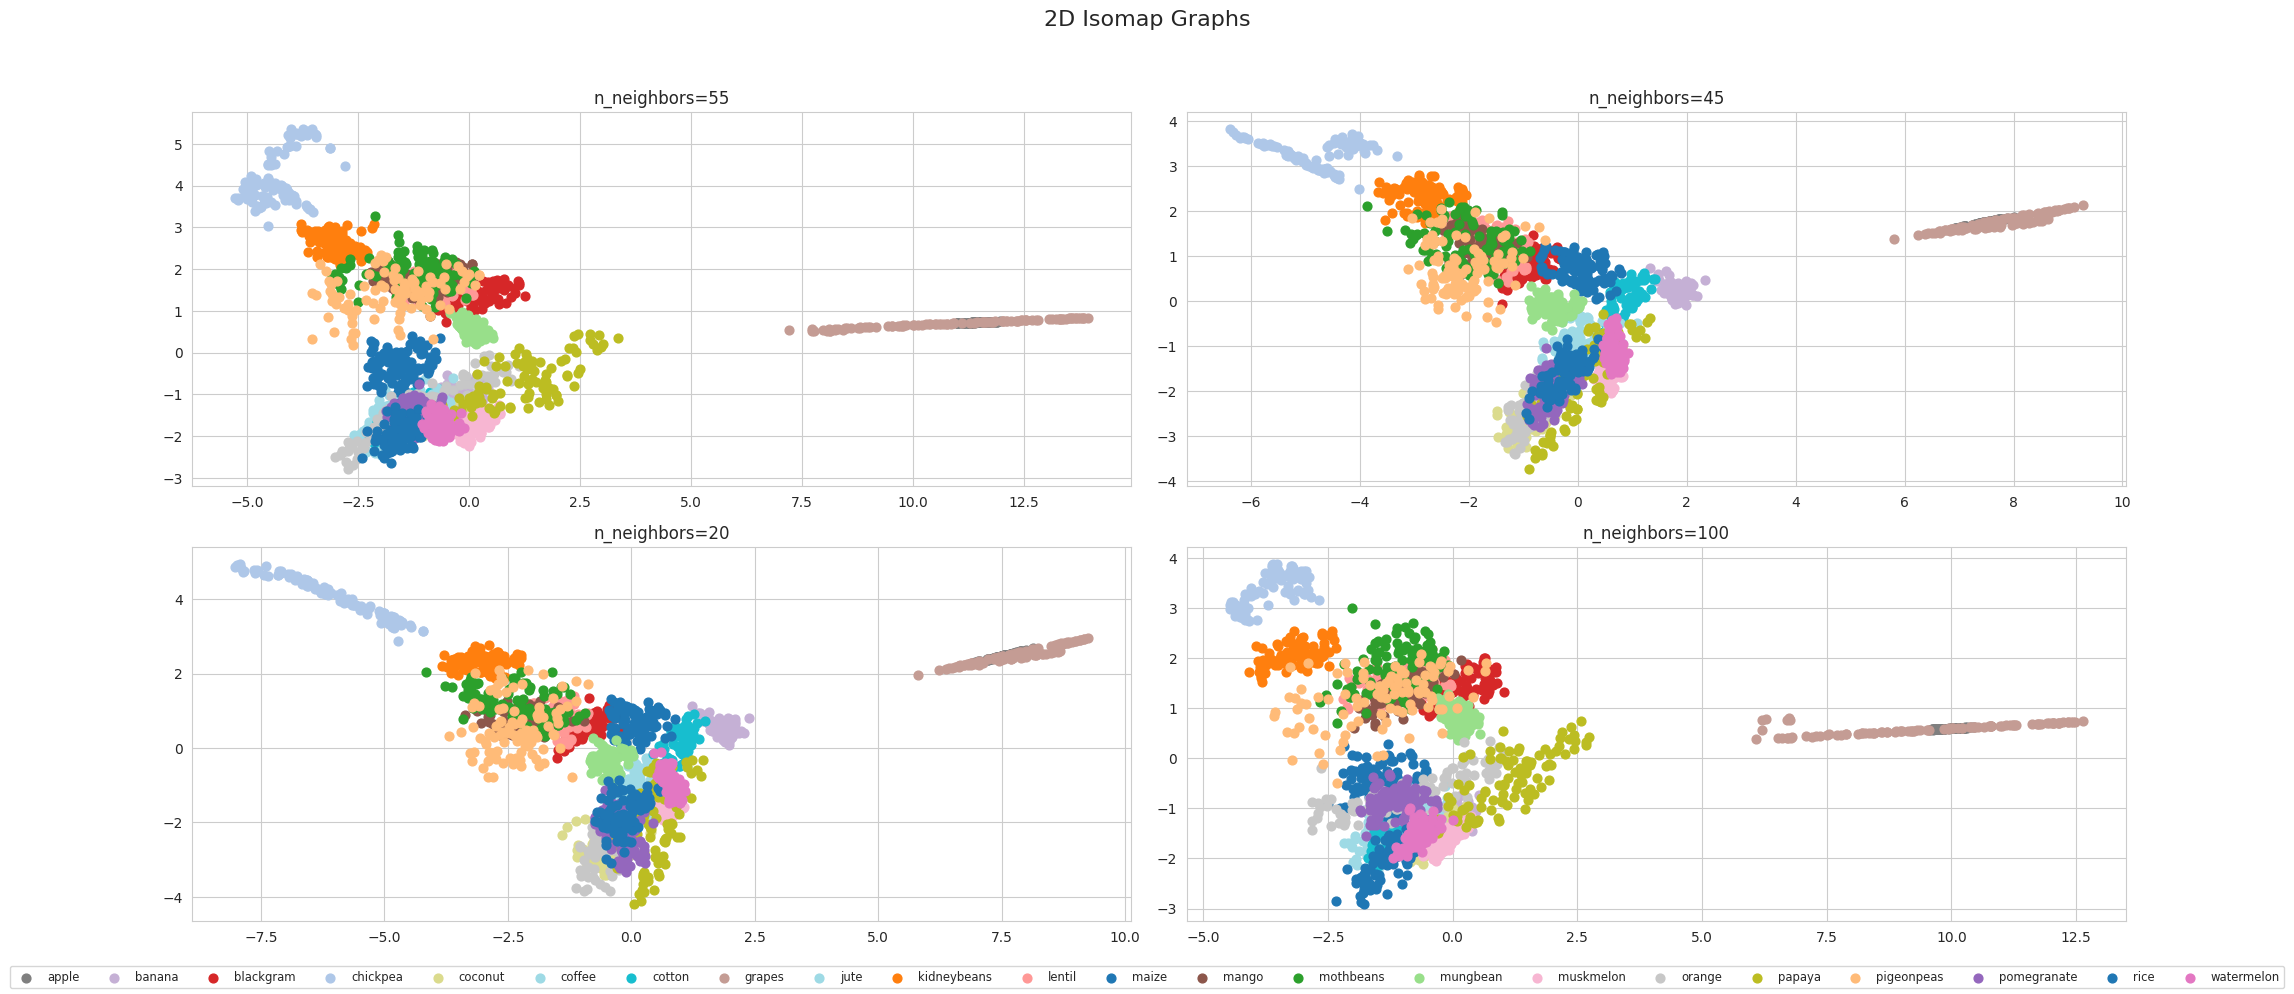

In [309]:
# Armamos grupos para cada isomap con diferentes n_neighbors
groups_100 = manifold_2D_100.groupby('label')
groups_55 = manifold_2D_55.groupby('label')
groups_45 = manifold_2D_45.groupby('label')
groups_20 = manifold_2D_20.groupby('label')

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
fig.suptitle('2D Isomap Graphs', fontsize=16)

# Creamos un colormap automático para los grupos
cmap = plt.cm.get_cmap('tab20', len(manifold_2D_55['label'].unique()))

# Iteramos a través de los grupos y asignanamos cada grupo a un subplot
legend_labels = []
for (groups, title, ax) in zip([groups_55, groups_45, groups_30, groups_100], ['n_neighbors=55', 'n_neighbors=45', 'n_neighbors=20', 'n_neighbors=100'], axes.flatten()):
    ax.set_title(title)

    for name, group in groups:
        color = cmap(manifold_2D_55['label'].unique().tolist().index(name))
        ax.scatter(group['PC1'], group['PC2'], label=name, s=40, color=color)

        if name not in legend_labels:
          legend_labels.append(name)

fig.legend(legend_labels, loc='lower center', fontsize='small', ncol=len(legend_labels))

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Al modificar el valor de n_neighbors se modifica la forma en que se construye el grafo de vecinos cercanos que se utiliza para calcular las distancias geodésicas. Por lo tanto, afecta la representación de las dimensiones reducidas que Isomap produce.


*   Disminuir n_neighbors puede llevar a una representación en dimensiones reducidas que es más sensible a los detalles locales y al ruido en los datos, pero puede ser más rápida de calcular computacionalmente.
*   Al aumentar n_neighbors se observa que los puntos están más dispersos, funcionará mejor para capturar estructuras globales en los datos y por lo tanto es más robusto frente al ruido. El costo computacional es mayor.

Un valor óptimo sería n_neighbors=55

Utilizamos n_components=2 ya que graficamos en 2D.



## t-SNE

In [35]:
import time
time_start = time.time()
tsne_df_40_700 = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=700)
tsneResults_40_700 = tsne_df_40_700.fit_transform(df_sub_std)

tsne_df_40_300 = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsneResults_40_300 = tsne_df_40_300.fit_transform(df_sub_std)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2200 samples in 0.005s...
[t-SNE] Computed neighbors for 2200 samples in 0.131s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2200
[t-SNE] Computed conditional probabilities for sample 2000 / 2200
[t-SNE] Computed conditional probabilities for sample 2200 / 2200
[t-SNE] Mean sigma: 0.517252
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.032440
[t-SNE] KL divergence after 700 iterations: 0.501858
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2200 samples in 0.003s...
[t-SNE] Computed neighbors for 2200 samples in 0.118s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2200
[t-SNE] Computed conditional probabilities for sample 2000 / 2200
[t-SNE] Computed conditional probabilities for sample 2200 / 2200
[t-SNE] Mean sigma: 0.517252
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.032440
[t-SNE] KL divergence after 300 iterations: 1.134031


In [36]:
time_start = time.time()
tsne_df_100_700 = TSNE(n_components=2, verbose=1, perplexity=100, n_iter=700)
tsneResults_100_700 = tsne_df_100_700.fit_transform(df_sub_std)

tsne_df_100_300 = TSNE(n_components=2, verbose=1, perplexity=100, n_iter=300)
tsneResults_100_300 = tsne_df_100_300.fit_transform(df_sub_std)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 2200 samples in 0.002s...
[t-SNE] Computed neighbors for 2200 samples in 0.229s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2200
[t-SNE] Computed conditional probabilities for sample 2000 / 2200
[t-SNE] Computed conditional probabilities for sample 2200 / 2200
[t-SNE] Mean sigma: 0.779592
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.675308
[t-SNE] KL divergence after 700 iterations: 0.340114
[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 2200 samples in 0.003s...
[t-SNE] Computed neighbors for 2200 samples in 0.232s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2200
[t-SNE] Computed conditional probabilities for sample 2000 / 2200
[t-SNE] Computed conditional probabilities for sample 2200 / 2200
[t-SNE] Mean sigma: 0.779592
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.675308
[t-SNE] KL divergence after 300 iterations: 0.687168


In [37]:
time_start = time.time()
tsne_df_20_700 = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=700)
tsneResults_20_700 = tsne_df_20_700.fit_transform(df_sub_std)

tsne_df_20_300 = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=300)
tsneResults_20_300 = tsne_df_20_300.fit_transform(df_sub_std)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 2200 samples in 0.002s...
[t-SNE] Computed neighbors for 2200 samples in 0.070s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2200
[t-SNE] Computed conditional probabilities for sample 2000 / 2200
[t-SNE] Computed conditional probabilities for sample 2200 / 2200
[t-SNE] Mean sigma: 0.398284
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.751076
[t-SNE] KL divergence after 700 iterations: 0.660164
[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 2200 samples in 0.003s...
[t-SNE] Computed neighbors for 2200 samples in 0.069s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2200
[t-SNE] Computed conditional probabilities for sample 2000 / 2200
[t-SNE] Computed conditional probabilities for sample 2200 / 2200
[t-SNE] Mean sigma: 0.398284
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.751076
[t-SNE] KL divergence after 300 iterations: 1.535134
t-

In [38]:
# Creo df susbsetTSNE, n_iter = 700
subsetTSNE = pd.DataFrame(df['label'])

# Creo df susbsetTSNE, n_iter = 300
subsetTSNE_300 = pd.DataFrame(df['label'])

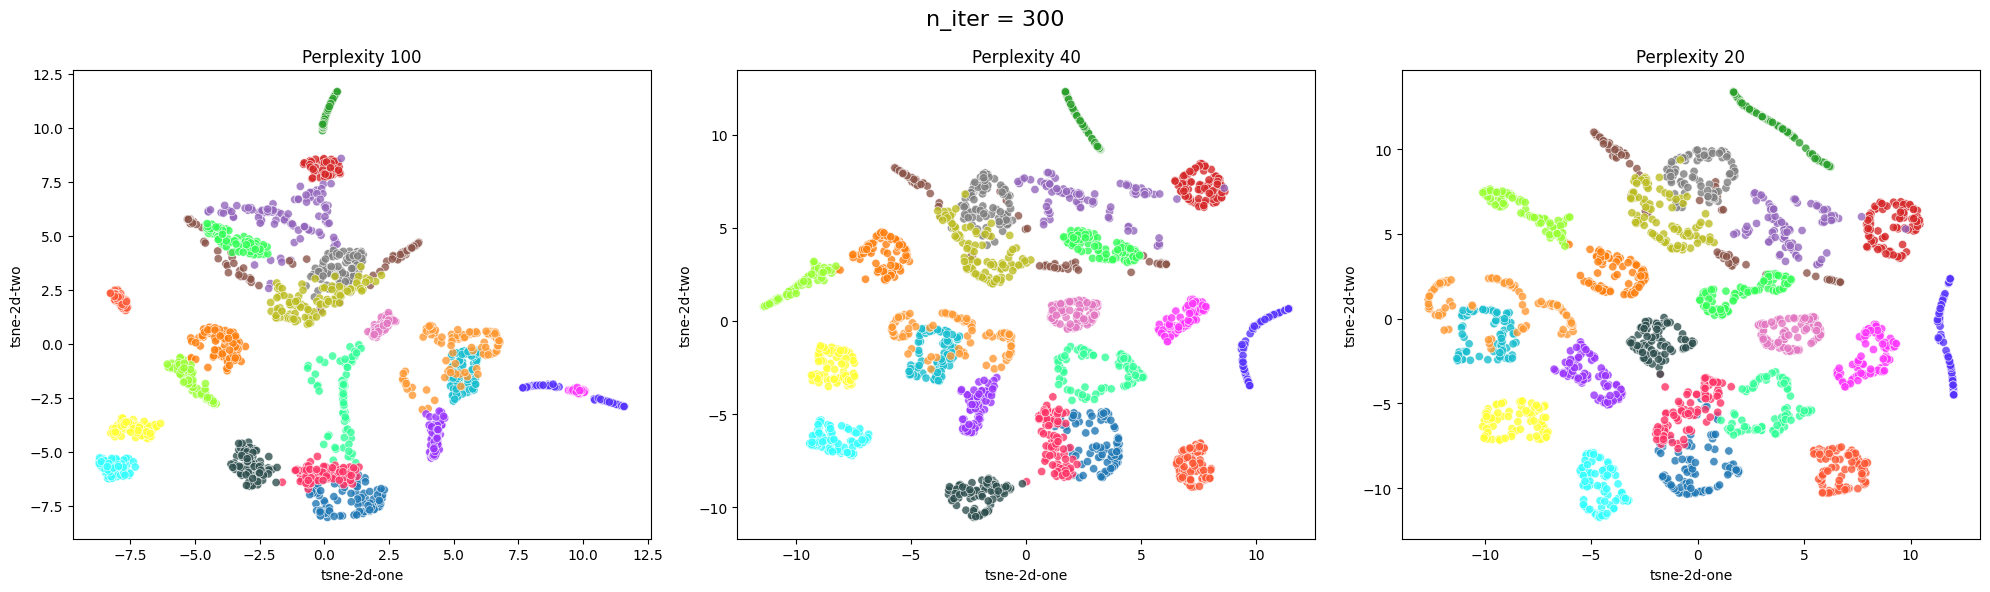

In [39]:
# Gráficos para distintas perplejidades, n_iter = 300
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
plt.suptitle("n_iter = 300", fontsize=16)

# Configurar el primer subplot
subsetTSNE_300['tsne-2d-one'] = tsneResults_100_300[:, 0]
subsetTSNE_300['tsne-2d-two'] = tsneResults_100_300[:, 1]
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="label",
    palette=sns.color_palette(custom_palette, 22),
    data=subsetTSNE_300,
    legend=False, alpha=0.8,
    ax=axes[0]  # Asignar al primer subplot
)
axes[0].set_title("Perplexity 100")

# Configurar el segundo subplot
subsetTSNE_300['tsne-2d-one'] = tsneResults_40_300[:, 0]
subsetTSNE_300['tsne-2d-two'] = tsneResults_40_300[:, 1]
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="label",
    palette=sns.color_palette(custom_palette, 22),
    data=subsetTSNE_300,
    legend=False, alpha=0.8,
    ax=axes[1]  # Asignar al segundo subplot
)
axes[1].set_title("Perplexity 40")

# Configurar el tercer subplot
subsetTSNE_300['tsne-2d-one'] = tsneResults_20_300[:, 0]
subsetTSNE_300['tsne-2d-two'] = tsneResults_20_300[:, 1]
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="label",
    palette=sns.color_palette(custom_palette, 22),
    data=subsetTSNE_300, legend=False,
    alpha=0.8,
    ax=axes[2]  # Asignar al tercer subplot
)
axes[2].set_title("Perplexity 20")

plt.tight_layout()
plt.show()

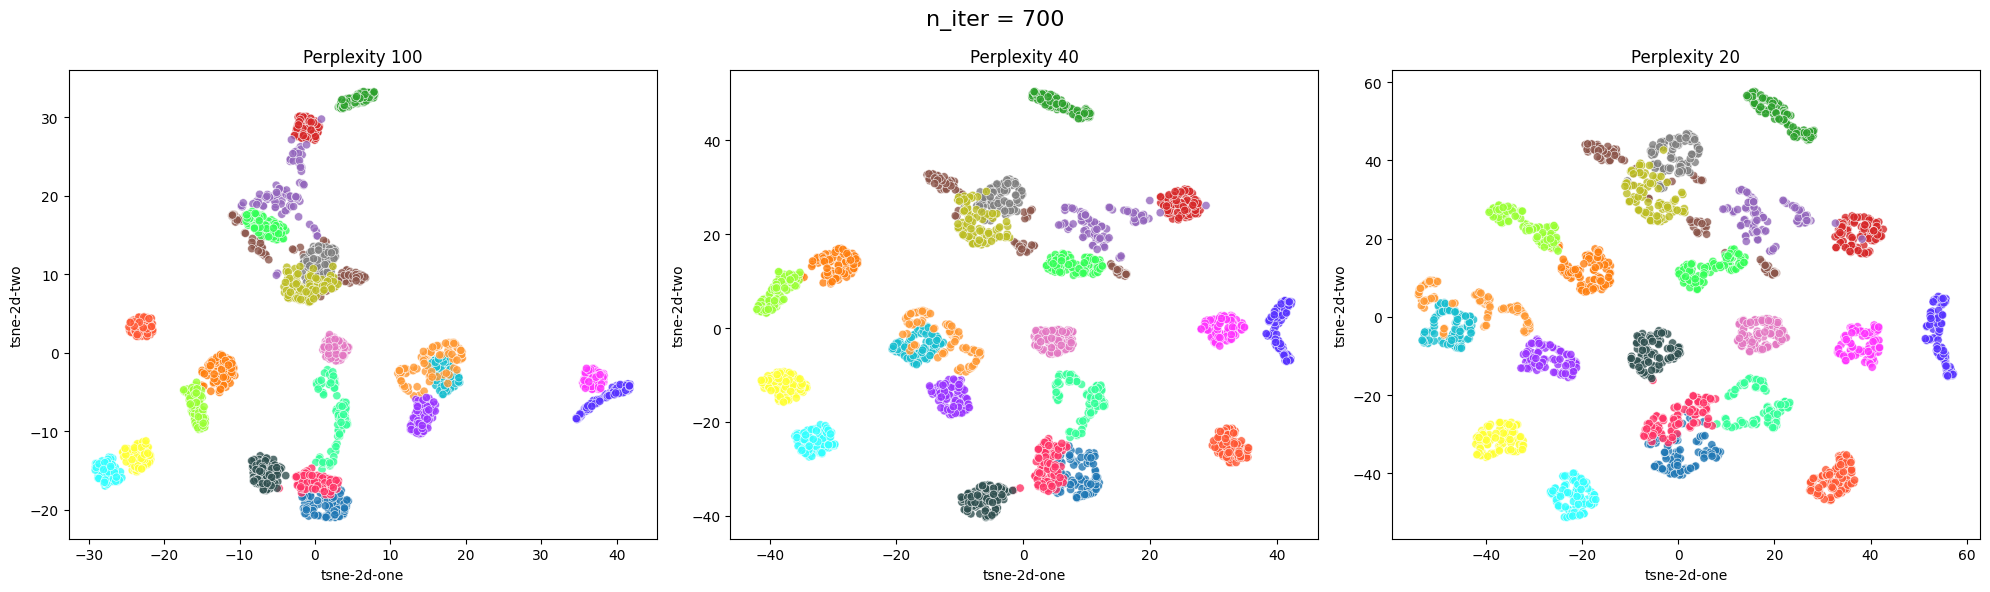

In [40]:
# Gráficos para distintas perplejidades, n_iter = 700
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
plt.suptitle("n_iter = 700", fontsize=16)

# Configurar el primer subplot
subsetTSNE['tsne-2d-one'] = tsneResults_100_700[:, 0]
subsetTSNE['tsne-2d-two'] = tsneResults_100_700[:, 1]

sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="label",
    palette=sns.color_palette(custom_palette, 22),
    data=subsetTSNE,
    legend=False, alpha=0.8,
    ax=axes[0]  # Asignar al primer subplot
)
axes[0].set_title("Perplexity 100")

# Configurar el segundo subplot
subsetTSNE['tsne-2d-one'] = tsneResults_40_700[:, 0]
subsetTSNE['tsne-2d-two'] = tsneResults_40_700[:, 1]
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="label",
    palette=sns.color_palette(custom_palette, 22),
    data=subsetTSNE,
    legend=False, alpha=0.8,
    ax=axes[1]  # Asignar al segundo subplot
)
axes[1].set_title("Perplexity 40")

# Configurar el tercer subplot
subsetTSNE['tsne-2d-one'] = tsneResults_20_700[:, 0]
subsetTSNE['tsne-2d-two'] = tsneResults_20_700[:, 1]
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="label",
    palette=sns.color_palette(custom_palette, 22),
    data=subsetTSNE, legend=False,
    alpha=0.8,
    ax=axes[2]  # Asignar al tercer subplot
)
axes[2].set_title("Perplexity 20")

plt.tight_layout()
plt.show()

Notamos que en el algoritmo t-SNE, cambiar los valores de n_iter y perplexity puede tener un impacto significativo en los resultados y en el rendimiento del algoritmo:

n_iters:

*   Aumentar el número de iteraciones puede ayudar a mejorar la calidad de la representación final ya que permite que el algoritmo tenga más tiempo para encontrar una representación óptima. Sin embargo, aumenta bastante el tiempo de cálculo.


*   Disminuir n_iter hará que el algoritmo se ejecute más rápidamente, pero puede resultar en representaciones subóptimas si no se ejecuta el tiempo suficiente para converger. Puede ser útil si necesitas resultados rápidos pero estás dispuesto a aceptar una ligera pérdida en la calidad de la representación.


perplexity:

*  Aumentar perplexity hace que cada punto considere más vecinos cercanos, por lo tanto, aumenta la influencia de los puntos distantes en el cálculo de las similitudes y puede hacer que el algoritmo ignore estructuras locales.

*  Disminuir perplexity hace que cada punto considere menos vecinos cercanos y se centre más en las estructuras locales. Esto puede ser útil para resaltar detalles finos en los datos, pero también puede hacer que el algoritmo sea más sensible al ruido.

A fin de cuentas, decidimos optar por n_ter=700 y perplexity=40.

Con estos parámetros se obtuvieron los mejores resultados.



## K-Means

### Cálculo del diagrama de codo

In [310]:
# Array del df estandarizado
X_scaled = np.array(df_sub_std)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

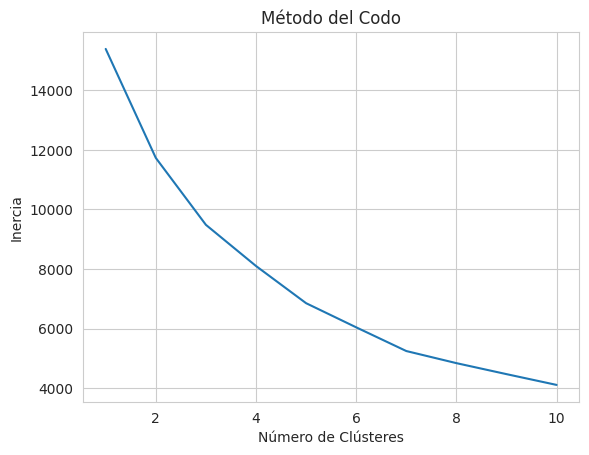

In [312]:
inercia = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(X_scaled)
    inercia[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(inercia.keys()), list(inercia.values()))
plt.title('Método del Codo')
plt.xlabel("Número de Clústeres")
plt.ylabel("Inercia")
plt.show()

El objetivo es identificar un punto en el gráfico donde la disminución en la suma de las distancias intraclúster (inercia) comienza a disminuir de manera significativamente más lenta. Este punto se denomina "codo" y sugiere el número óptimo de clústeres para el conjunto de datos.

En este caso, no se visualiza una disminución tan marcada pero notamos que a partir del cluster 5 se observa un leve declive en la curva.

In [315]:
# Modelo con n_clusters=5
kmeans = KMeans(n_clusters=5)
kmeans.fit(X_scaled) #Entrenamos el modelo

# El metodo labels_ nos da a que cluster corresponde cada observacion
df_cluster = df_sub.copy()
df_cluster['Cluster KMeans'] = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [316]:
df_cluster.head()

,N,P,K,temperature,humidity,ph,rainfall,Cluster KMeans
0,90,42,43,20.879744,82.002744,6.502985,202.935536,2
1,85,58,41,21.770462,80.319644,7.038096,226.655537,2
2,60,55,44,23.004459,82.320763,7.840207,263.964248,2
3,74,35,40,26.491096,80.158363,6.980401,242.864034,2
4,78,42,42,20.130175,81.604873,7.628473,262.717340,2


In [74]:
# Calculamos por cada cluster el promedio de cada atributo
df_cluster.groupby('Cluster KMeans').mean()

,N,P,K,temperature,humidity,ph,rainfall
Cluster KMeans,,,,,,,
0,99.459750,41.491950,37.506261,25.634957,78.639280,6.437042,75.952024
1,48.987889,32.823529,34.110727,24.542126,85.185466,6.516116,168.115685
2,28.652542,67.457627,45.466102,19.706561,23.466186,6.417866,98.663369
3,21.990000,133.375000,200.000000,23.240259,87.104305,5.977800,91.133304
4,25.743222,52.052632,23.151515,29.572003,65.557379,6.631671,74.132023


In [317]:
centroids = kmeans.cluster_centers_
centroids

array([[-0.77366958,  2.42565201,  2.99816611, -0.46921466,  0.70170042,
        -0.63529696, -0.22435795],
       [-0.67260884, -0.03671911, -0.49324082,  0.7803758 , -0.26967337,
         0.20466538, -0.53419098],
       [-0.04516403, -0.62285694, -0.27840851, -0.21130454,  0.61377284,
         0.06267039,  1.1736135 ],
       [ 1.32479587, -0.35987448, -0.21013356,  0.0036956 ,  0.32148588,
        -0.04191262, -0.50059021],
       [-0.5893423 ,  0.42871511, -0.04884459, -1.17505085, -2.16646898,
        -0.06062166, -0.08998535]])

In [318]:
# Vemos el conteo de datos por cluster
observaciones_por_cluster = df_cluster['Cluster KMeans'].value_counts().sort_index()
observaciones_por_cluster

0    200
1    627
2    580
3    559
4    234
Name: Cluster KMeans, dtype: int64

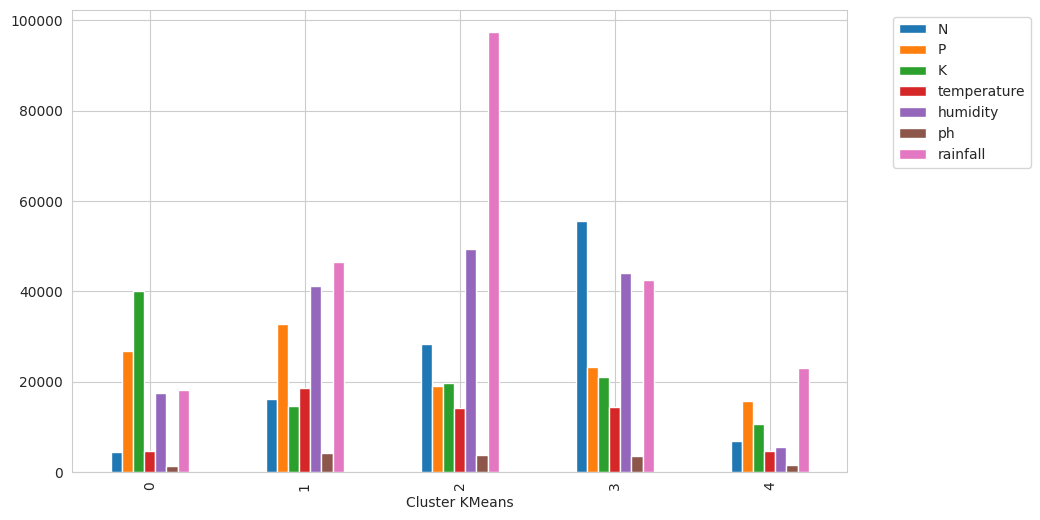

In [319]:
df_cluster.groupby('Cluster KMeans').sum().plot(kind='bar', figsize=(10, 6))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

Notamos cuán influyente es cada variable en nuestros clusters. Por ejemplo, vemos que en el cluster 2 tenemos la mayor cantidad de observaciones de 'rainfall' y en el cluster 3 la mayor cantidad de 'N'. Por otro lado, en el cluster 4 tenemos la menor cantidad de observaciones.

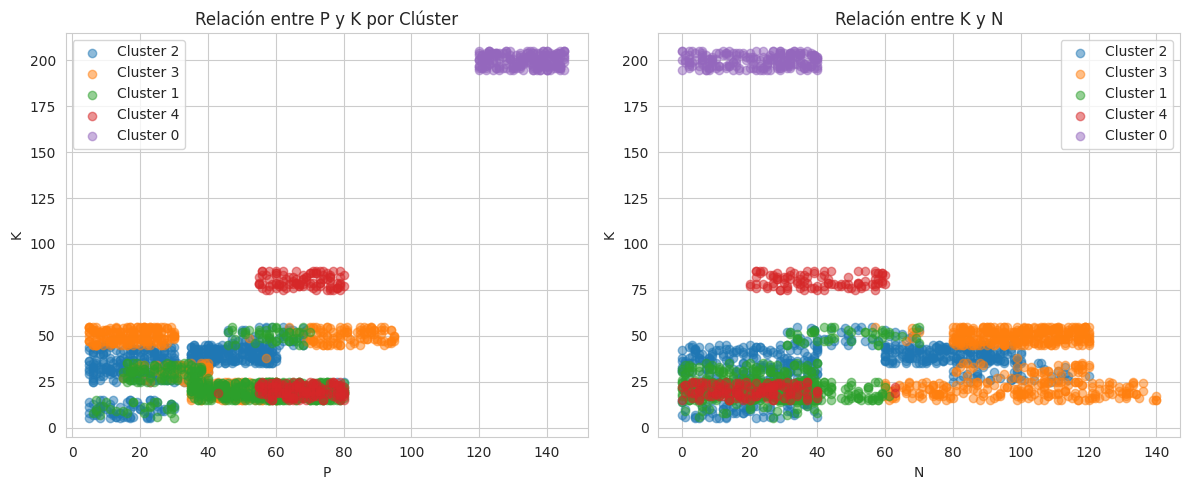

In [321]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

plt.sca(ax[0])
for cluster_label in df_cluster['Cluster KMeans'].unique():
    cluster_data = df_cluster[df_cluster['Cluster KMeans'] == cluster_label]
    plt.scatter(cluster_data['P'], cluster_data['K'], label=f'Cluster {cluster_label}', alpha=0.5)

plt.xlabel('P')
plt.ylabel('K')
plt.title('Relación entre P y K por Clúster')
plt.legend()

plt.sca(ax[1])
for cluster_label in df_cluster['Cluster KMeans'].unique():
    cluster_data = df_cluster[df_cluster['Cluster KMeans'] == cluster_label]
    plt.scatter(cluster_data['N'], cluster_data['K'], label=f'Cluster {cluster_label}', alpha=0.5)

plt.xlabel('N')
plt.ylabel('K')
plt.title('Relación entre K y N')
plt.legend()

plt.tight_layout()

plt.show()

Observando relaciones entre algunas variables, por ejemplo vemos que en el cluster 2 tenemos muy bajas cantidades de P y K y en el cluster 0 tenemos las más altas de estos dos, pero muy bajas de N.

El cluster 3 presenta bajas cantidades de K pero muy altas de N.



---


Para darnos una idea de manera gráfica sobre como quedaron conformados los clusters y debido a que tenemos muchas caracteristicas y no es posible hacer un gráfico que las represente a todas, realizamos el análisis de componentes principales PCA.

Si se armaron grupos definidos deberiamos poder visualizar grupos separados a ojo y así confirmar que KMeans categorizó bien y no quedaron grupos superpuestos.

In [324]:
pca_2 = PCA(n_components=2)
componentes_principales = pca_2.fit_transform(X_scaled)

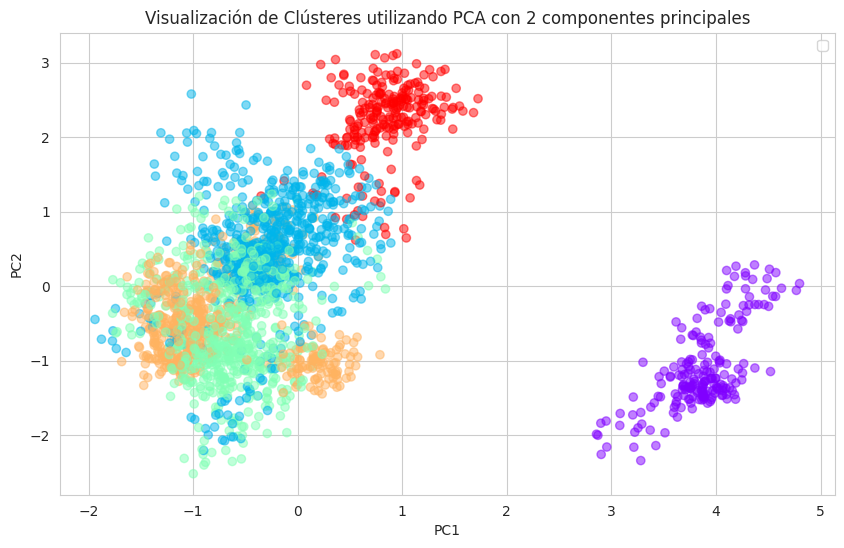

In [327]:
plt.figure(figsize=(10, 6))
plt.scatter(componentes_principales[:, 0], componentes_principales[:, 1], c=df_cluster['Cluster KMeans'] ,cmap='rainbow', alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Visualización de Clústeres utilizando PCA con 2 componentes principales')
plt.legend()
plt.show()

 Gráfico 3D utilizando los atributos N, P y K

In [138]:
fig = px.scatter_3d(df_cluster, x='N', y='P', z='K',
              color=df_cluster["Cluster KMeans"],  labels={'color': 'Cluster'}, color_discrete_sequence=custom_palette)
fig.update_traces(marker_size=5)
fig.show()

Notamos que hay algunos grupos definidos, como el cluster 3.

Muchos otros están superpuestos, por lo tanto KMeans no pudo realizar un agrupamiento o categorización satisfactoria de los datos.

## Gap Statistic
Utilizamos GAP para conocer el número óptimo de clusters para el modelo

In [139]:
def calculate_intra_cluster_dispersion(X, k):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    return kmeans.inertia_

In [116]:
gaps = []
max_k = 15
for k in range(1, max_k + 1):
    # Calculo la inercia real sobre mis datos reales
    real_inertia = calculate_intra_cluster_dispersion(X_scaled, k)
    #Calculo la inercia de datos aleatorios con la mismsa estrucutra que mis datos originales
    inertia_list = []
    for _ in range(10):
      random_data = np.random.rand(*X_scaled.shape)
      intra_cluster_dispersion = calculate_intra_cluster_dispersion(random_data, k)
      inertia_list.append(intra_cluster_dispersion)

    reference_inertia = np.mean(inertia_list)

    #Aplico la funcion de gap
    gap = np.log(reference_inertia) - np.log(real_inertia)
    gaps.append(gap)


optimal_k = np.argmax(gaps) + 1

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

Número óptimo de clusters según el Gap Statistic: 15


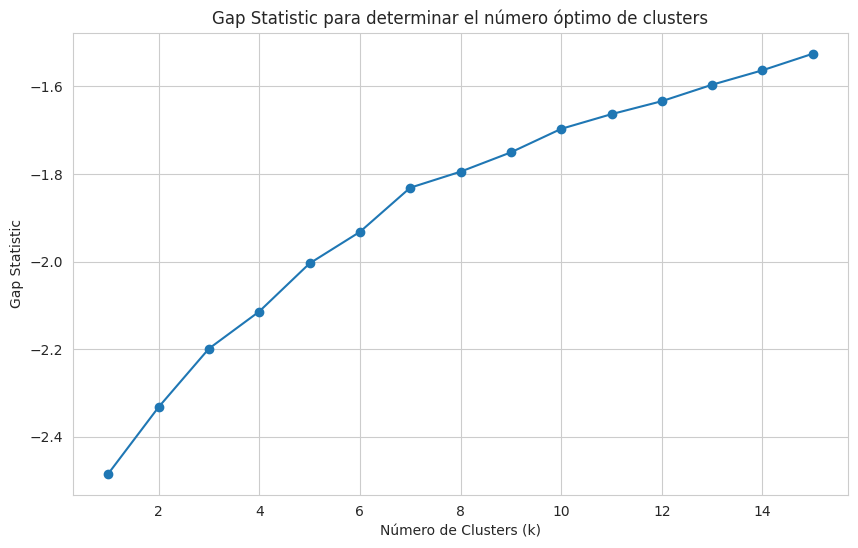

In [117]:
print("Número óptimo de clusters según el Gap Statistic:", optimal_k)

plt.figure(figsize=(10, 6))
plt.plot(range(1, max_k + 1), gaps, marker='o')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Gap Statistic')
plt.title('Gap Statistic para determinar el número óptimo de clusters')
plt.show()

Utilizando OptimalK de la librería gap_statistic

In [123]:
!pip install gap_stat

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gap_stat: filename=gap_stat-2.0.3-py3-none-any.whl size=6133 sha256=151ce42278b9ffd7456759b171a685fc29d31b27b9e65f239e3d54d365f83b8c
  Stored in directory: /root/.cache/pip/wheels/e6/75/de/ee29b366258cdeccdacaff94d895b9d2ffc95a486f3b982441
Successfully built gap_stat


In [124]:
from gap_statistic import OptimalK
gs_obj = OptimalK(n_jobs=1, n_iter= 100)
n_clusters = gs_obj(X_scaled, n_refs=50, cluster_array=np.arange(1, 15))
print('Optimal number of clusters: ', n_clusters)

Optimal number of clusters:  14


Obtuvimos, mediante el uso de GAP, el número óptimo de clusters, que estará entre 14 y 15

Creamos el modelo para n_clusters=15

In [143]:
# Modelo con n_clusters=15
kmeans_15 = KMeans(n_clusters=15)
kmeans_15.fit(X_scaled) #Entrenamos el modelo

# El metodo labels_ nos da a que cluster corresponde cada observacion
df_cluster_15 = df_sub.copy()
df_cluster_15['Cluster Kmeans'] = kmeans_15.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



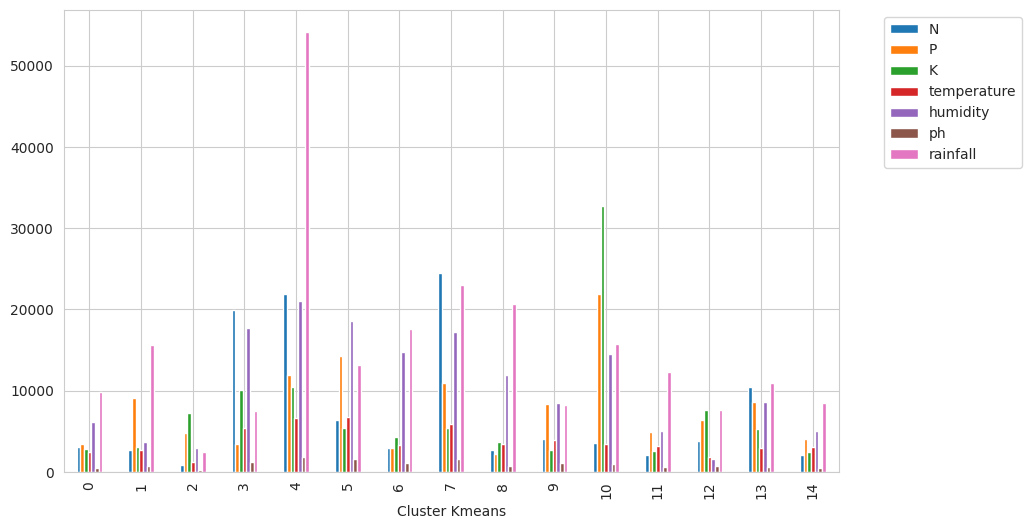

In [146]:
df_cluster_15.groupby('Cluster Kmeans').sum().plot(kind='bar', figsize=(10, 6))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [148]:
# Gráfico 3D utilizando los atributos N, P y K
fig = px.scatter_3d(df_cluster_15, x='N', y='P', z='K',
              color=df_cluster_15["Cluster Kmeans"],  labels={'color': 'Cluster'}, color_discrete_sequence=custom_palette)
fig.update_traces(marker_size=5)
fig.show()

Aún así, construyendo el modelo con 15 clusters, el resultado de KMeans a la hora de categorizar los datos fue bastante malo.

Pensamos que esto puede deberse a que los datos están desbalanceados y a que puede haber características que están haciendo más fuerte ese desbalance.

Para saciar esto, procedemos a realizar PCA para reducir dimensionalidad y aplicar el modelo nuevamente pero ahora a las componentes principales.

### Aplicando PCA

In [328]:
# Modelo para 2 componentes
pca_kmeans = PCA(n_components=2)
componentes_principales2 = pca_kmeans.fit_transform(df_sub_std)

In [329]:
componentes_principales2 = pd.DataFrame(componentes_principales2)
componentes_principales2.columns = ['PC1', 'PC2']

In [330]:
componentes_principales2.head(3)

,PC1,PC2
0,-0.582737,-0.844394
1,-0.474527,-0.784716
2,-0.633924,-0.694365


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

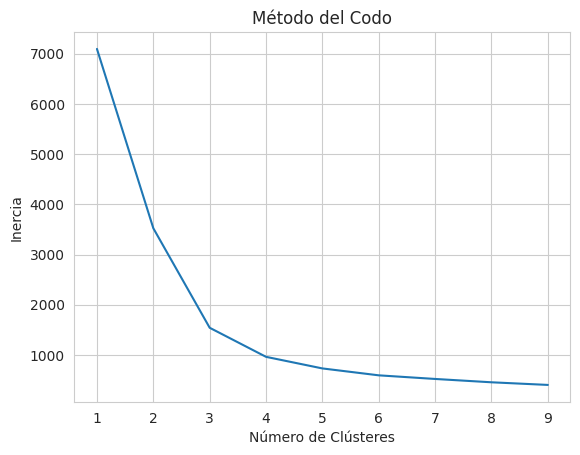

In [331]:
inercia = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(componentes_principales2)
    inercia[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(inercia.keys()), list(inercia.values()))
plt.title('Método del Codo')
plt.xlabel("Número de Clústeres")
plt.ylabel("Inercia")
plt.show()

A partir del método del codo visualizamos que en el cluster número 3 ocurre un quiebre pronunciado.

In [332]:
kmeans_pca = KMeans(n_clusters=3)
kmeans_pca.fit(componentes_principales2)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



KMeans(n_clusters=3)

In [333]:
centroids2 = kmeans_pca.cluster_centers_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



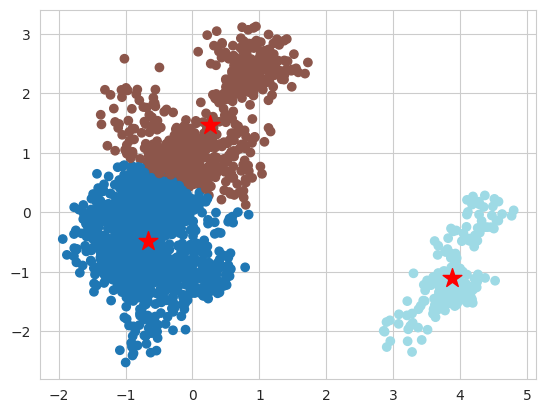

In [351]:
# Visializamos el clustering
plt.scatter(componentes_principales2['PC1'], componentes_principales2['PC2'],
           c = KMeans(n_clusters = 3).fit_predict(componentes_principales2), cmap ='tab20')
plt.scatter(centroids2[:, 0], centroids2[:, 1], marker='*', s=200, c='red')
plt.show()

In [337]:
# Modelo para 3 componentes
pca_kmeans_3d = PCA(n_components=3)
componentes_principales3 = pca_kmeans_3d.fit_transform(df_sub_std)

In [338]:
componentes_principales3 = pd.DataFrame(componentes_principales3)
componentes_principales3.columns = ['P1', 'P2', 'P3']

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

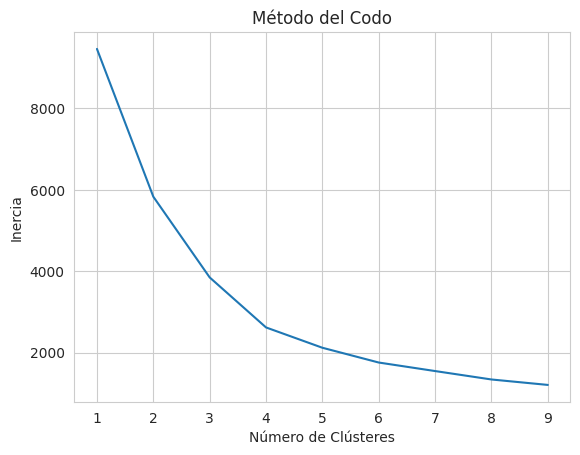

In [339]:
inercia = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(componentes_principales3)
    inercia[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(inercia.keys()), list(inercia.values()))
plt.title('Método del Codo')
plt.xlabel("Número de Clústeres")
plt.ylabel("Inercia")
plt.show()

In [352]:
# Gráfico 3D
paleta = ['#1f77b4','#ff7f0e','#2ca02c']
fig = px.scatter_3d(componentes_principales3, x='P1', y='P2', z='P3', color=KMeans(n_clusters=3).fit_predict(componentes_principales3), labels={'color': 'Cluster'}, color_continuous_scale=paleta)
fig.update_coloraxes(showscale=True, colorbar_title="Cluster", colorbar_ticks="outside", colorbar_dtick=1)
fig.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [366]:
# Gráfico 3D para 14 clusters
fig = px.scatter_3d(componentes_principales3, x='P1', y='P2', z='P3', color=KMeans(n_clusters=14).fit_predict(componentes_principales3), labels={'color': 'Cluster'}, color_continuous_scale=custom_palette)
fig.update_coloraxes(showscale=True, colorbar_title="Cluster", colorbar_ticks="outside", colorbar_dtick=1)
fig.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Aplicando PCA y luego realizando KMeans a esas componentes principales obtenidas pudimos observar como los datos se han podido categorizar de una manera mucho mas fuerte.

El método del codo nos arrojo un óptimo de 3 clusters, donde visualizamos que se agruparon bien los datos en esos 3 clusters, sin superponerse casi en su totalidad.

Dedicimos aplicar KMeans con 14 clusters a las componentes principales, ya que era el número óptimo de clusters que arrojaba GAP anteriormente. En este caso pudimos ver que también se han categorizado muy bien.

Claramente, utilizando PCA previo a KMeans, se pudo realizar una mucho mejor categorización de los datos.

## Clustering Jerárquico

In [354]:
# Armamos la matriz de enlace con los datos normalizados
Z = linkage(X_scaled, "ward") # ward -> reduce varianza intracluster (la suma de distancias entre clusters sea la mínima)

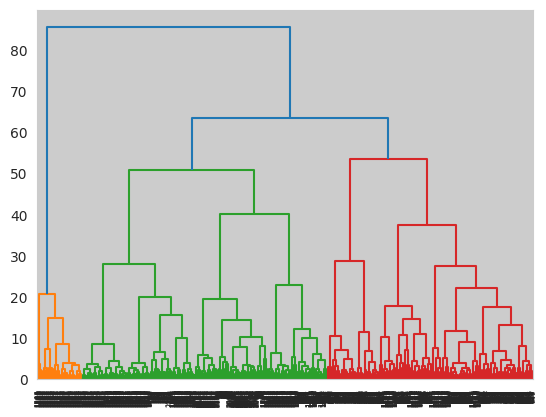

In [355]:
# Creamos el dendrograma
dendrogram(Z)
plt.show()

Analizamos un dendrograma un poco más limpio, truncandolo en los últimos 20 grupos, sabiendo que no vamos a definir más de 20 clusters

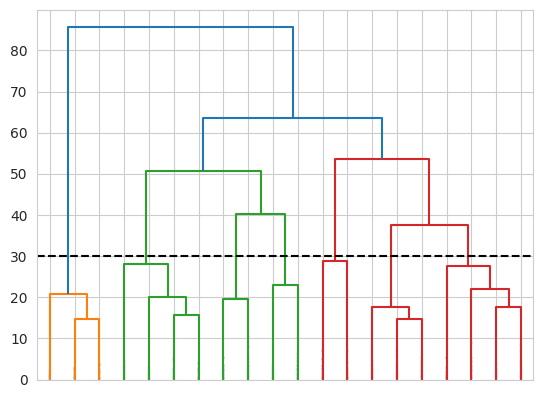

In [356]:
dendrogram(Z,  truncate_mode = 'lastp', p = 20, show_leaf_counts = False, show_contracted = True)
plt.axhline(y=30, c='k', linestyle='dashed')
plt.show()

Definimos cortar el dendrograma en y=30, por lo que vamos a calcular un total de 7 clusters.

Método del codo para clustering jerárquico

In [358]:
distancias=[]
for i in range(1, 30):
    clustering = AgglomerativeClustering(n_clusters=i)
    clustering.fit(X_scaled)

    # Calculo la matriz de distancias entre puntos
    pairwise_distances = cdist(X_scaled, X_scaled, 'euclidean')

    # Calculo la distancia total entre los clusters
    distancia_total = 0
    for j in range(i):
        cluster_indices = np.where(clustering.labels_ == j)
        distancia_total += pairwise_distances[cluster_indices][:, cluster_indices].sum()

    distancias.append(distancia_total)

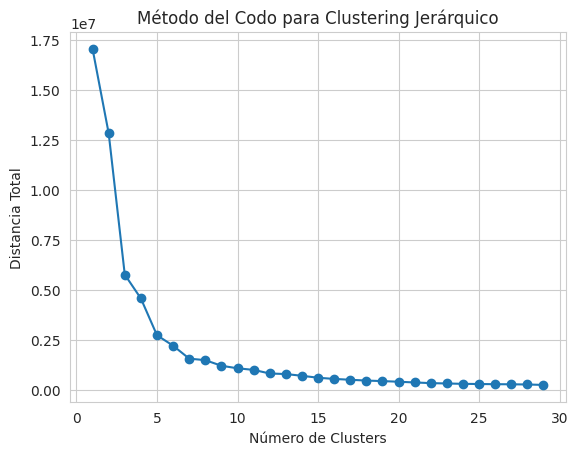

In [359]:
plt.plot(range(1, 30), distancias, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Distancia Total')
plt.title('Método del Codo para Clustering Jerárquico')
plt.show()


In [360]:
n_clusters = 7
clustering = AgglomerativeClustering(n_clusters=n_clusters)

cluster_assignments = clustering.fit_predict(X_scaled)

df_cluster['Cluster Jer'] = cluster_assignments

df_cluster.head()

,N,P,K,temperature,humidity,ph,rainfall,Cluster KMeans,Cluster Jer
0,90,42,43,20.879744,82.002744,6.502985,202.935536,2,5
1,85,58,41,21.770462,80.319644,7.038096,226.655537,2,5
2,60,55,44,23.004459,82.320763,7.840207,263.964248,2,5
3,74,35,40,26.491096,80.158363,6.980401,242.864034,2,5
4,78,42,42,20.130175,81.604873,7.628473,262.717340,2,5


A partir del dendrograma y del método del codo aplicado a clustering jerárquico, decidimos que el óptimo de clusters es 7.

Notamos a simple vista que se guarda una relación entre los clusters de KMeans y los clusters jerárquicos calculados recién.

### Silhouette

In [361]:
def calculate_silhouette(X_scaled, k, linkage='ward'):
    clustering = AgglomerativeClustering(n_clusters=k, linkage=linkage)
    labels = clustering.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, labels)
    sample_silhouette_values = silhouette_samples(X_scaled, labels)

    return silhouette_avg, sample_silhouette_values

max_k = 15

silhouette_scores = []
for k in range(2, max_k + 1):
    silhouette_avg, _ = calculate_silhouette(X_scaled, k)
    silhouette_scores.append(silhouette_avg)

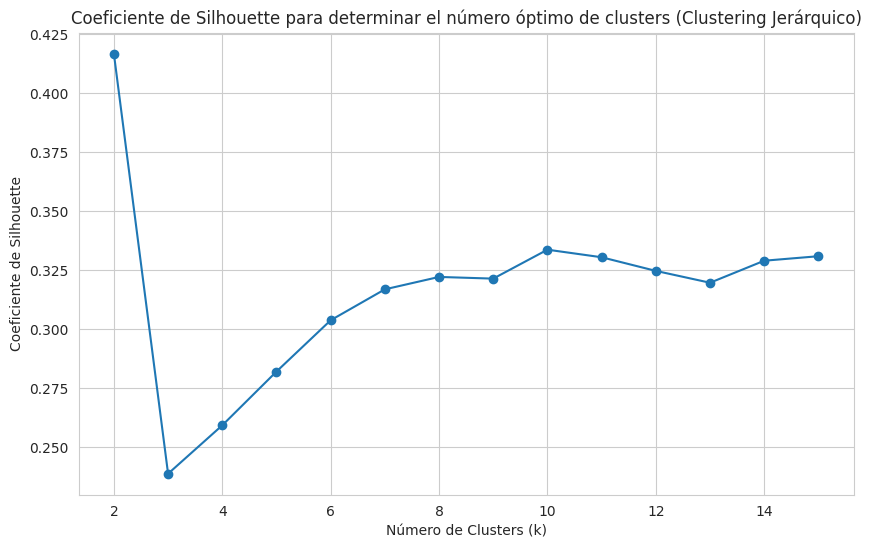

In [362]:
plt.figure(figsize=(10, 6))
plt.plot(range(2, max_k + 1), silhouette_scores, marker='o')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Coeficiente de Silhouette')
plt.title('Coeficiente de Silhouette para determinar el número óptimo de clusters (Clustering Jerárquico)')
plt.show()

Utilizando el score de Silhouette, notamos que el score comienza a aumentar a partir del cluster 3 y optar por entre 8 y 10 clusters sería lo correcto.

### Gap Statistic


In [363]:
# Función para calcular la inercia
def calculate_intra_cluster_dispersion(X_scaled, k, linkage='ward'):
    clustering = AgglomerativeClustering(n_clusters=k, linkage=linkage)
    labels = clustering.fit_predict(X_scaled)
    centroids = np.array([np.mean(X_scaled[labels == i], axis=0) for i in range(k)])
    intra_cluster_dispersion = np.sum(np.linalg.norm(X_scaled[labels] - centroids[labels], axis=1)**2)

    return intra_cluster_dispersion

In [364]:
gaps = []
max_k = 15
for k in range(1, max_k + 1):
    real_inertia = calculate_intra_cluster_dispersion(X_scaled, k, linkage='ward')

    inertia_list = []
    for _ in range(10):
      random_data = np.random.rand(*X_scaled.shape)
      intra_cluster_dispersion = calculate_intra_cluster_dispersion(random_data, k)
      inertia_list.append(intra_cluster_dispersion)

    reference_inertia = np.mean(inertia_list)

    gap = np.log(reference_inertia) - np.log(real_inertia)
    gaps.append(gap)

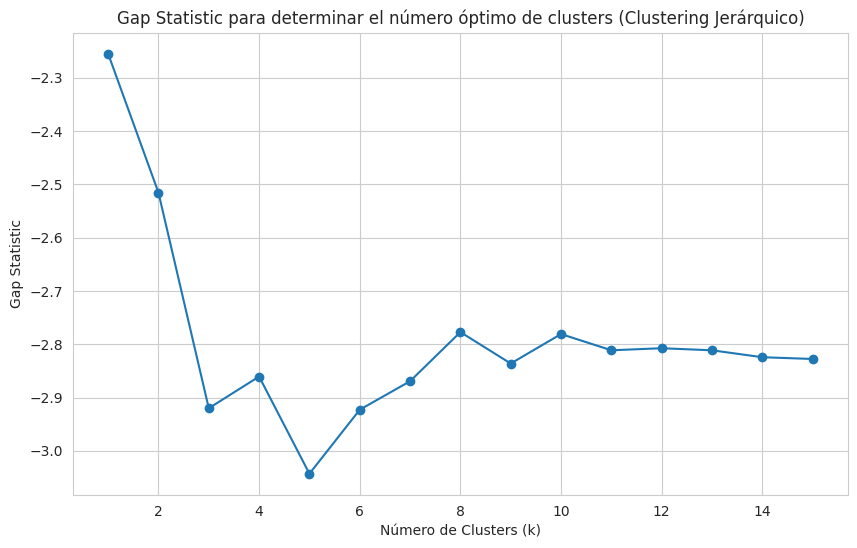

In [365]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_k + 1), gaps, marker='o')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Gap Statistic')
plt.title('Gap Statistic para determinar el número óptimo de clusters (Clustering Jerárquico)')
plt.show()

Aplicando GAP, también notamos que 7 clusters sería una cantidad óptima de clusters para utilizar.